In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import numpy as np
import pandas as pd

# NN

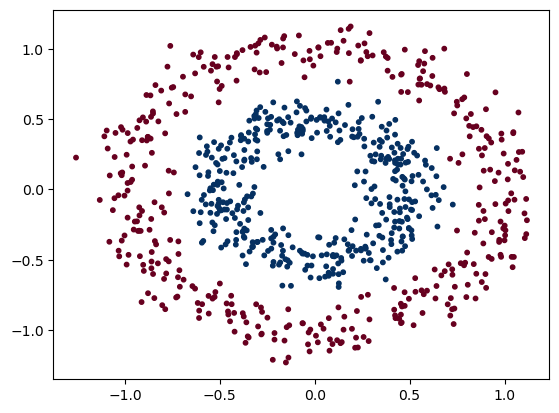

In [2]:
# Create a circles dataset
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)

# Plot data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.RdBu)

In [3]:
# torch.manual_seed(42)
torch.manual_seed(150)

model = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 7),
    nn.ReLU(),
    nn.Linear(7, 6),
    nn.ReLU(),
    nn.Linear(6, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
    nn.Sigmoid()
)

print(model)
model_cpy = copy.deepcopy(model)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=7, bias=True)
  (3): ReLU()
  (4): Linear(in_features=7, out_features=6, bias=True)
  (5): ReLU()
  (6): Linear(in_features=6, out_features=4, bias=True)
  (7): ReLU()
  (8): Linear(in_features=4, out_features=2, bias=True)
  (9): Sigmoid()
)


In [4]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [100/1000], Loss: 0.3729, Val Loss: 0.3749
Epoch [200/1000], Loss: 0.3176, Val Loss: 0.3493
Epoch [300/1000], Loss: 0.3157, Val Loss: 0.3483
Epoch [400/1000], Loss: 0.3151, Val Loss: 0.3474
Epoch [500/1000], Loss: 0.3147, Val Loss: 0.3469
Epoch [600/1000], Loss: 0.3144, Val Loss: 0.3461
Epoch [700/1000], Loss: 0.3142, Val Loss: 0.3471
Epoch [800/1000], Loss: 0.3141, Val Loss: 0.3474
Epoch [900/1000], Loss: 0.3139, Val Loss: 0.3472
Epoch [1000/1000], Loss: 0.3139, Val Loss: 0.3465


In [10]:
torch.save(model.state_dict(), 'model.pickle')

In [121]:
# torch.unique(model(X_val_tensor))
y_val_outputs = model(X_val_tensor).argmax(dim=-1)
(y_val_outputs == y_val_tensor).sum().item() / len(y_val_tensor)

0.965

In [12]:
# # Apply L1 structured pruning
# from torch.nn.utils import prune

# # Specify the amount of pruning
# amount = 0.5

# # Prune the model
# for module in model.layers:
#     if isinstance(module, nn.Linear):
#         prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)

# # Print sparsity of each layer
# for module in model.layers:
#     if isinstance(module, nn.Linear):
#         print(f"Sparsity in {module}: {100. * float(torch.sum(module.weight == 0)) / float(module.weight.nelement()):.2f}%")


In [20]:
import pruning_methods as pm

oneshot_pruned_model = pm.oneshot_pruning_reinit(model, model_cpy, 2, 2, 0.6)

In [21]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(oneshot_pruned_model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    # model.train()
    outputs = oneshot_pruned_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        oneshot_pruned_model.eval()
        with torch.no_grad():
            val_outputs = oneshot_pruned_model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [100/1000], Loss: 0.5707, Val Loss: 0.5916
Epoch [200/1000], Loss: 0.4896, Val Loss: 0.5287
Epoch [300/1000], Loss: 0.4562, Val Loss: 0.5004
Epoch [400/1000], Loss: 0.4476, Val Loss: 0.4933
Epoch [500/1000], Loss: 0.4437, Val Loss: 0.4915
Epoch [600/1000], Loss: 0.4417, Val Loss: 0.4901
Epoch [700/1000], Loss: 0.4407, Val Loss: 0.4891
Epoch [800/1000], Loss: 0.4401, Val Loss: 0.4887
Epoch [900/1000], Loss: 0.4397, Val Loss: 0.4881
Epoch [1000/1000], Loss: 0.4393, Val Loss: 0.4881


In [22]:
# torch.unique(model(X_val_tensor))
y_val_outputs = oneshot_pruned_model(X_val_tensor).argmax(dim=-1)
(y_val_outputs == y_val_tensor).sum().item() / len(y_val_tensor)

0.825

# Regression, Reliability

Epoch [100/1000], Loss: 91.0993, Val Loss: 90.0911
Epoch [200/1000], Loss: 26.5138, Val Loss: 26.1577
Epoch [300/1000], Loss: 6.4684, Val Loss: 6.3785
Epoch [400/1000], Loss: 2.0463, Val Loss: 2.0305
Epoch [500/1000], Loss: 1.3561, Val Loss: 1.3541
Epoch [600/1000], Loss: 1.2662, Val Loss: 1.2659
Epoch [700/1000], Loss: 1.2417, Val Loss: 1.2415
Epoch [800/1000], Loss: 1.2221, Val Loss: 1.2219
Epoch [900/1000], Loss: 1.2031, Val Loss: 1.2029
Epoch [1000/1000], Loss: 1.1849, Val Loss: 1.1847


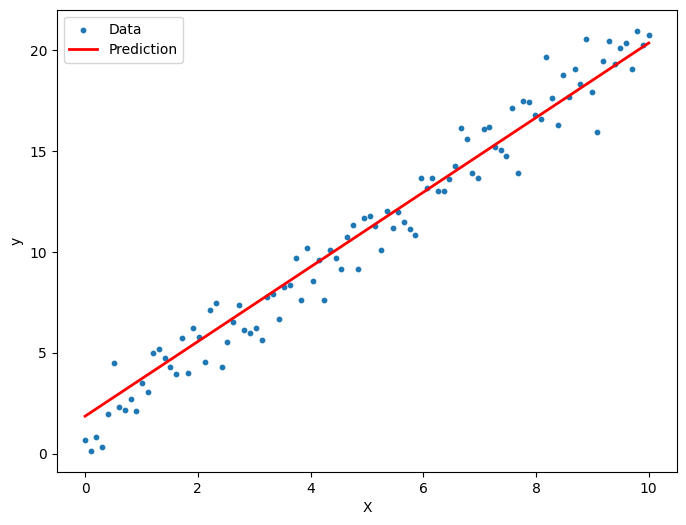

In [16]:
# Linear Regression dataset using PyTorch tensors
X = np.linspace(0, 10, 100)
y = 2*X + 1 + np.random.normal(0, 1, *X.shape)

# NN model for linear Regression
model = nn.Sequential(
    nn.Linear(1, 1)
)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X.reshape(-1, 1))
y_train_tensor = torch.FloatTensor(y.reshape(-1, 1))

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_train_tensor)
            val_loss = criterion(val_outputs, y_train_tensor)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Plot the data and the model prediction
plt.figure(figsize=(8, 6))
plt.scatter(X, y, s=10, label='Data')
plt.plot(X, model(X_train_tensor).detach().numpy(), color='red', linewidth=2, label='Prediction')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

In [23]:
import scipy.stats as st

def reliability_diagram_reg(mean, sigma, Y, color="blue", label="Model", marker_size=6):
    fig, ax = plt.subplots()
    df = pd.DataFrame()
    df["mean"] = mean
    df["sigma"] = sigma
    df["Y"] = Y
    df["z"] = (df["Y"] - df["mean"]) / df["sigma"]
    df["perc"] = st.norm.cdf(df["z"])
    k = np.arange(0, 1.1, 0.1)
    counts = []
    df2 = pd.DataFrame()
    df2["Interval"] = k
    df2["Ideal"] = k
    for i in range(0, 11):
        l = df[df["perc"] < 0.5 + i * 0.05]
        l = l[l["perc"] >= 0.5 - i * 0.05]
        counts.append(len(l) / len(df))
    df2["Counts"] = counts

    ax.plot(k, counts, color=color, label=label)

    ax.scatter(k, counts, color=color,s=marker_size)
    ax.scatter(k, k,color="green",s=marker_size)
    ax.set_yticks(k)
    ax.set_xticks(k)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    # ax.legend()
    ax.set_xlabel("decile")
    ax.set_ylabel("ratio of points")
    ax.plot(k, k, color="green")

def reliability_diagram_classification(prediction, trueY, nbins=10):
    """
    prediction: numpy array of predictions
    trueY: numpy array of true labels
    nbins: number of bins to use for the reliability diagram
    """
    # Create a dataframe with the predictions and true labels
    df = pd.DataFrame()
    df["prediction"] = prediction
    df["trueY"] = trueY

    # Sort the dataframe by the predictions
    df = df.sort_values(by="prediction")

    # Create bins for the predictions
    bins = np.linspace(0, 1, nbins + 1)
    df["bins"] = pd.cut(df["prediction"], bins=bins, include_lowest=True)

    # Calculate the average predictions and true labels for each bin
    df = df.groupby("bins").mean().reset_index()

    # Plot the reliability diagram
    plt.figure(figsize=(8, 6))
    plt.plot(df["prediction"], df["trueY"], marker="o", linewidth=2)
    plt.plot([0, 1], [0, 1], color="green")
    plt.xlabel("Mean prediction")
    plt.ylabel("True label")
    plt.show()


In [38]:
bins = np.linspace(0, 1, 11)
np.digitize(oneshot_pruned_model(X_train_tensor).detach().numpy()[:, 0], bins=bins, right=True)

array([ 1, 10, 10, 10,  1, 10,  1,  1, 10, 10,  1,  3, 10, 10,  1, 10, 10,
       10, 10,  1,  1,  1,  1,  1,  1,  1, 10, 10, 10, 10, 10,  1,  1,  1,
        1, 10,  1,  1,  1,  1,  1,  1, 10,  1, 10,  1, 10,  1, 10,  6, 10,
        1, 10,  1,  1,  1,  1,  1,  1,  1, 10, 10,  1,  1, 10,  1,  1,  1,
       10, 10, 10,  1,  1,  1, 10, 10, 10, 10,  1, 10,  1,  1, 10,  1, 10,
        1, 10,  1, 10,  1,  1,  1, 10, 10, 10,  1, 10,  1,  1, 10, 10, 10,
        1, 10, 10,  1,  1, 10,  1, 10,  1,  1,  1, 10,  1, 10,  1,  1, 10,
        1, 10,  1,  1,  1, 10,  1, 10,  1,  1,  1,  1,  1,  1,  1,  1, 10,
       10,  1,  1,  1,  1,  1, 10,  1,  1,  1,  1, 10, 10, 10,  1,  1, 10,
        1,  5,  1,  1, 10, 10,  1,  1, 10,  1,  1,  1,  1,  1, 10,  1,  1,
       10, 10,  1,  1,  1,  1,  1,  1,  1,  1, 10,  1,  1,  1, 10,  1,  4,
       10,  1, 10, 10,  1,  1, 10,  1,  1,  1,  1,  1,  1, 10, 10, 10,  1,
        1,  1, 10, 10,  1, 10, 10, 10,  1, 10,  1,  1,  1,  1,  1, 10,  1,
       10, 10, 10, 10, 10

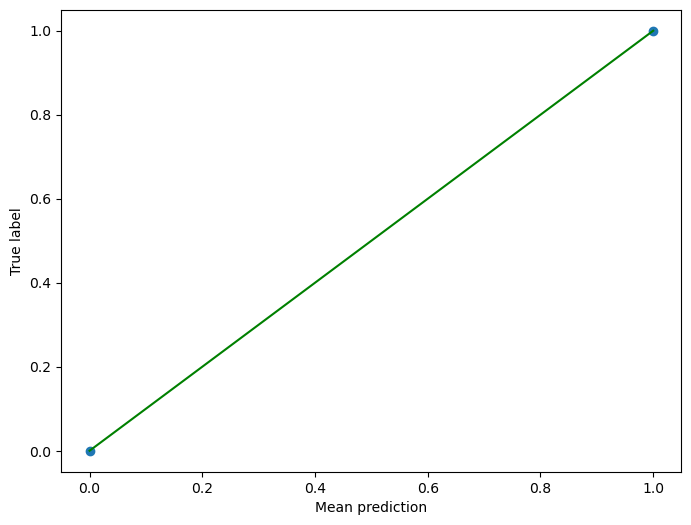

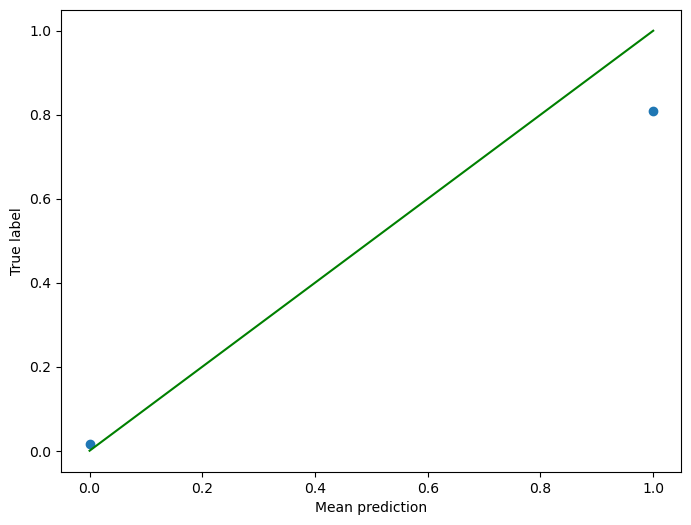

In [35]:
reliability_diagram_classification(np.argmax(model(X_train_tensor).detach().numpy(), axis = 1), y_train_tensor.detach().numpy(), nbins=10)
reliability_diagram_classification(np.argmax(oneshot_pruned_model(X_train_tensor).detach().numpy(), axis = 1), y_train_tensor.detach().numpy(), nbins=10)
# np.argmax(model(X_train_tensor).detach().numpy(), axis = 1)
# y_train_tensor.detach().numpy()

In [151]:
def expected_calibration_error_classification(samples, true_labels, M=3):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    # keep confidences / predicted "probabilities" as they are
    # confidences = samples
    # get binary class predictions from confidences
    # predicted_label = (samples>0.5).astype(float)
    # get max probability per sample i                 
    confidences = np.max(samples, axis=1)               
    # get predictions from confidences (positional in this case)
    predicted_label = np.argmax(samples, axis=1).astype(float)

    

    print(confidences.shape, predicted_label.shape, true_labels.shape)

    # get a boolean list of correct/false predictions
    accuracies = np.equal(predicted_label, true_labels)
    print(accuracies.shape)

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        print(in_bin.shape, accuracies.shape, confidences.shape)
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prop_in_bin = in_bin.astype(float).mean()

        if prop_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].astype(float).mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece

In [153]:

# predictions = model(X_train_tensor).detach().numpy().reshape(-1,)
# predictions = model(X_train_tensor).max(dim=-1)[0].detach().numpy().reshape(-1,)
predictions = oneshot_pruned_model(X_train_tensor).detach().numpy()
# print(predictions.shape)
# y_pred = y_pred.detach().numpy()

true_labels = y_train_tensor.detach().numpy().reshape(-1,)
# print(true_labels.shape)

# get max probability per sample i                 
# confidences = np.max(predictions, axis=1)               
# get predictions from confidences (positional in this case)
# predicted_label = np.argmax(predictions, axis=1).astype(float)

# (predicted_label == true_labels)
# sigma = np.ones((len(predictions),))
expected_calibration_error_classification(predictions, true_labels)

# reliability_diagram(predictions, sigma, true_labels)
# plt.show()


(800,) (800,) (800,)
(800,)
(800,) (800,) (800,)
(800,) (800,) (800,)
(800,) (800,) (800,)


array([0.11878206])